In [1]:
# %reload_ext autoreload
# %autoreload 2

In [2]:
import argparse

import numpy as np
import stheno.torch as stheno
import torch
from tqdm.auto import tqdm
from tensorboardX import SummaryWriter
import convcnp.data
from convcnp.architectures import SimpleConv, UNet
from convcnp.cnp import RegressionANP as ANP
from convcnp.cnp import RegressionCNP as CNP
from convcnp.experiment import (
    report_loss,
    RunningAverage,
    generate_root,
    WorkingDirectory,
    save_checkpoint
)
from convcnp.set_conv import ConvCNP
from convcnp.utils import device, gaussian_logpdf



# Data

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import torch

def npsample_batch(x, y, size=None, sort=True):
    """Sample from numpy arrays along 2nd dim."""
    inds = np.random.choice(range(x.shape[1]), size=size, replace=False)
    if sort:
        inds.sort()
    return x[:, inds], y[:, inds]

def collate_fns(max_num_context, max_num_extra_target, sample, sort=True, context_in_target=True):
    def collate_fn(batch, sample=sample):
        # Collate
        x = np.stack([x for x, y in batch], 0)
        y = np.stack([y for x, y in batch], 0)

        # Sample a subset of random size
        num_context = np.random.randint(4, max_num_context)
        num_extra_target = np.random.randint(4, max_num_extra_target)

        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()

        # Last feature will show how far in time a point is from out last context
        assert (np.diff(x[:, :, 0], 1)>=0).all(), 'first features should be ordered e.g. seconds'
        assert (x[:, max_num_context, -1]==0.).all(), 'last features should be empty'
        time = x[:, :, 0]
        t0 = x[:, max_num_context, 0][:, None]
        x[:, :, -1] = time - t0  # Feature to let the model know this is past data
        
        x_context = x[:, :max_num_context]
        y_context = y[:, :max_num_context]
    
        x_target_extra = x[:, max_num_context:]
        y_target_extra = y[:, max_num_context:]
        
        if sample:

            # This is slightly differen't than normal, we are ensuring that our target point are in the future, to mimic deployment
            x_context, y_context = npsample_batch(
                x_context, y_context, size=num_context, sort=sort
            )

            x_target_extra, y_target_extra = npsample_batch(
                x_target_extra, y_target_extra, size=num_extra_target, sort=sort
            )

        # do we want to compute loss over context+target_extra, or focus in on only target_extra?
        if context_in_target:
            x_target = torch.cat([x_context, x_target_extra], 1)
            y_target = torch.cat([y_context, y_target_extra], 1)
        else:
            x_target = x_target_extra
            y_target = y_target_extra

        assert (x[:, -1, -1] > 0).all()
        assert (x[:, 0, -1] < 0).all()
        
#         return x_context, y_context, x_target, y_target
        return dict(x=x, y=y, x_context=x_context, y_context=y_context, x_target=x_target, y_target=y_target)


    return collate_fn


class SmartMeterDataSet(torch.utils.data.Dataset):
    def __init__(self, df, num_context=40, num_extra_target=10, label_names=['energy(kWh/hh)']):
        self.df = df
        self.num_context = num_context
        self.num_extra_target = num_extra_target
        self.label_names = label_names

    def get_rows(self, i):
        rows = self.df.iloc[i : i + (self.num_context + self.num_extra_target)].copy()
        rows['tstp'] = (rows['tstp'] - rows['tstp'].iloc[0]).dt.total_seconds() / 86400.0
        rows = rows.sort_values('tstp')

        # make sure tstp, which is our x axis, is the first value
        columns = ['tstp'] + list(set(rows.columns) - set(['tstp'])) + ['future']
        rows['future'] = 0.
        rows = rows[columns]

        # This will be the last row, and will change it upon sample to let the model know some points are in the future

        x = rows.drop(columns=self.label_names).copy()
        y = rows[self.label_names].copy()
        return x, y


    def __getitem__(self, i):
        x, y = self.get_rows(i)
        return x.values, y.values
        
    def __len__(self):
        return len(self.df) - (self.num_context + self.num_extra_target)

def get_smartmeter_df(indir=Path('./data/smart-meters-in-london'), use_logy=False):
    csv_files = sorted(Path('data/smart-meters-in-london/halfhourly_dataset').glob('*.csv'))[:1]
    df = pd.concat([pd.read_csv(f, parse_dates=[1], na_values=['Null']) for f in csv_files])
#     print(df.info())

    df = df.groupby('tstp').mean()
    df['tstp'] = df.index
    df.index.name = ''

    # Load weather data
    df_weather = pd.read_csv(indir/'weather_hourly_darksky.csv', parse_dates=[3])

    use_cols = ['visibility', 'windBearing', 'temperature', 'time', 'dewPoint',
           'pressure', 'apparentTemperature', 'windSpeed', 
           'humidity']
    df_weather = df_weather[use_cols].set_index('time')

    # Resample to match energy data    
    df_weather = df_weather.resample('30T').ffill()

    # Normalise
    weather_norms=dict(mean={'visibility': 11.2,
     'windBearing': 195.7,
     'temperature': 10.5,
     'dewPoint': 6.5,
     'pressure': 1014.1,
     'apparentTemperature': 9.2,
     'windSpeed': 3.9,
     'humidity': 0.8},
    std={'visibility': 3.1,
     'windBearing': 90.6,
     'temperature': 5.8,
     'dewPoint': 5.0,
     'pressure': 11.4,
     'apparentTemperature': 6.9,
     'windSpeed': 2.0,
     'humidity': 0.1})

    for col in df_weather.columns:
        df_weather[col] -= weather_norms['mean'][col]
        df_weather[col] /= weather_norms['std'][col]

    df = pd.concat([df, df_weather], 1).dropna()
    
    
    # Also find bank holidays
    df_hols = pd.read_csv(indir/'uk_bank_holidays.csv', parse_dates=[0])
    holidays = set(df_hols['Bank holidays'].dt.round('D'))

    df['holiday'] = df.tstp.apply(lambda dt:dt.floor('D') in holidays).astype(int)

    # Add time features
    time = df.tstp
    df["month"] = time.dt.month / 12.0
    df['day'] = time.dt.day / 310.0
    df['week'] = time.dt.week / 52.0
    df['hour'] = time.dt.hour / 24.0
    df['minute'] = time.dt.minute / 24.0
    df['dayofweek'] = time.dt.dayofweek / 7.0

    # Drop nan and 0's
    df = df[df['energy(kWh/hh)']!=0]
    df = df.dropna()

    if use_logy:
        df['energy(kWh/hh)'] = np.log(df['energy(kWh/hh)']+1e-4)
    df = df.sort_values('tstp')
    
    # split data
    n_split = -int(len(df)*0.1)
    df_train = df[:n_split]
    df_test = df[n_split:]
    return df_train, df_test


# Helpers

In [4]:
from convcnp.utils import (
    device
)

def validate(data, model, report_freq=None):
    """Compute the validation loss."""
    ravg = RunningAverage()
    model.eval()
    with torch.no_grad():
        for step, task in enumerate(tqdm(data)):
            for k in task.keys(): task[k] = task[k].to(device)
            y_mean, y_std = \
                model(task['x_context'], task['y_context'], task['x_target'])
            obj = \
                -gaussian_logpdf(task['y_target'], y_mean, y_std,
                                 'batched_mean')
            ravg.update(obj.item() / data.batch_size, data.batch_size)
            if report_freq:
                report_loss('Validation', ravg.avg, step, report_freq)
    return ravg.avg


def train(data, model, opt, report_freq):
    """Perform a training epoch."""
    ravg = RunningAverage()
    model.train()
    for step, task in enumerate(tqdm(data)):
        for k in task.keys(): task[k] = task[k].to(device)
        y_mean, y_std = model(task['x_context'], task['y_context'],
                              task['x_target'])
        obj = -gaussian_logpdf(task['y_target'], y_mean, y_std, 'batched_mean')
        obj.backward()
        opt.step()
        opt.zero_grad()
        ravg.update(obj.item() / data.batch_size, data.batch_size)
        report_loss('Training', ravg.avg, step, report_freq)
    return ravg.avg


In [5]:
from matplotlib import pyplot as plt

def to_numpy(x):
    """Convert a PyTorch tensor to NumPy."""
    return x.squeeze().detach().cpu().numpy()


def plot(gen, model, name):
    label = "energy(kWh/hh)"
    # Make prediction
#     task = next(iter(gen))
    task = gen_val.collate_fn([gen_val.dataset[670]])
    for k in task.keys(): task[k] = task[k].to(device)
    x_context = task['x_context'][:1]
    y_context = task['y_context'][:1]
    x_target = task['x_target'][:1]
    y_target = task['y_target'][:1]
    x_all = task['x'][:1]
    y_all = task['y'][:1]


    y_mean, y_std = model(x_context, y_context,
                                  x_target)

    
    # sort target for pred & plotting
    inds_target = torch.argsort(x_target[0, :, 0])
    x_target = x_target[:, inds_target]
    y_target = y_target[:, inds_target]
    y_mean = y_mean[:, inds_target]
    y_std = y_std[:, inds_target]

    # Plot context set.
    plt.scatter(to_numpy(x_target)[:, 0], to_numpy(y_target), label='Target Set', s=20, color='grey', alpha=0.5)
    plt.scatter(to_numpy(x_context)[:, 0], to_numpy(y_context), label='Context Set', color='black')    
    plt.plot(to_numpy(x_all)[:, 0], to_numpy(y_all), '--',  label='Sampled function', color='gray', alpha=0.9)
    ylims = plt.ylim()

    # Plot model predictions.
    plt.plot(to_numpy(x_target)[0:, 0], to_numpy(y_mean), label='%s Output' % name, color='blue')
    plt.fill_between(to_numpy(x_target)[ :, 0],
                     to_numpy(y_mean + 1 * y_std),
                     to_numpy(y_mean - 1 * y_std),
                     color='tab:blue', alpha=0.2)
#     plt.ylim(-3., 3)
#     plt.axis('off')
    plt.ylim(*ylims)
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.grid(b=None)
    plt.legend()
    plt.show()

In [6]:
# plot(gen_val, model, args.model)

# Args

In [7]:


# Parse arguments given to the script.
parser = argparse.ArgumentParser()
parser.add_argument('data',
                    choices=['eq',
                             'matern',
                             'noisy-mixture',
                             'weakly-periodic',
                             'sawtooth', 'smartmeter'],
                    help='Data set to train the CNP on. ')
parser.add_argument('model',
                    choices=['convcnp', 'convcnpxl', 'cnp', 'anp'],
                    help='Choice of model. ')
parser.add_argument('--root',
                    help='Experiment root, which is the directory from which '
                         'the experiment will run. If it is not given, '
                         'a directory will be automatically created.')
parser.add_argument('--train',
                    action='store_true',
                    help='Perform training. If this is not specified, '
                         'the model will be attempted to be loaded from the '
                         'experiment root.')
parser.add_argument('--epochs',
                    default=100,
                    type=int,
                    help='Number of epochs to train for.')
parser.add_argument('--learning_rate',
                    default=1e-3,
                    type=float,
                    help='Learning rate.')
parser.add_argument('--weight_decay',
                    default=1e-5,
                    type=float,
                    help='Weight decay.')
args = parser.parse_args(['smartmeter', 'convcnp', '--train', '--epochs','500'])

# Run

In [8]:
df_train, df_test = get_smartmeter_df()
data_train = SmartMeterDataSet(
            df_train, 24, 24
)
x, y = data_train[0]
x.shape, y.shape

((48, 17), (48, 1))

In [9]:
hparams = dict(
    num_context=24*4,
    num_extra_target=24*4,
    num_workers=3,
    batch_size=16,
    context_in_target=True
    
)

data_train = SmartMeterDataSet(
    df_train, hparams["num_context"], hparams["num_extra_target"]
)
loader_train = torch.utils.data.DataLoader(
    data_train,
    batch_size=hparams["batch_size"],
    shuffle=True,
    collate_fn=collate_fns(
        hparams["num_context"], hparams["num_extra_target"], sample=True, context_in_target=hparams["context_in_target"]
    ),
    num_workers=hparams["num_workers"],
)


data_test = SmartMeterDataSet(
    df_test, hparams["num_context"], hparams["num_extra_target"]
)
loader_val = loader_test = torch.utils.data.DataLoader(
    data_test,
    batch_size=hparams["batch_size"],
    shuffle=False,
    collate_fn=collate_fns(
        hparams["num_context"], hparams["num_extra_target"], sample=False, context_in_target=hparams["context_in_target"]
    ),
)

In [10]:

# Load working directory.
if args.root:
    wd = WorkingDirectory(root=args.root)
else:
    experiment_name = f'{args.model}-{args.data}'
    wd = WorkingDirectory(root=generate_root(experiment_name))

# Load data generator.
gen = loader_train
gen_test = gen_val = loader_val

# Load model.
if args.model == 'convcnp':
    model = ConvCNP(learn_length_scale=True,
                    points_per_unit=64,
                    architecture=SimpleConv(),
                    x_dim=17,
                    y_dim=1
                   )
elif args.model == 'convcnpxl':
    model = ConvCNP(learn_length_scale=True,
                    points_per_unit=64,
                    architecture=UNet())
elif args.model == 'cnp':
    model = CNP(latent_dim=128)
elif args.model == 'anp':
    model = ANP(latent_dim=128)
else:
    raise ValueError(f'Unknown model {args.model}.')

model.to(device)

# Perform training.
opt = torch.optim.Adam(model.parameters(),
                       args.learning_rate,
                       weight_decay=args.weight_decay)

writer = SummaryWriter(wd.root)

Root: _experiments/2020-02-23_16-04-47_convcnp-smartmeter


In [11]:
r = next(iter(gen))
{k:v.shape for k,v in r.items()}

{'x': torch.Size([16, 192, 17]),
 'y': torch.Size([16, 192, 1]),
 'x_context': torch.Size([16, 49, 17]),
 'y_context': torch.Size([16, 49, 1]),
 'x_target': torch.Size([16, 77, 17]),
 'y_target': torch.Size([16, 77, 1])}

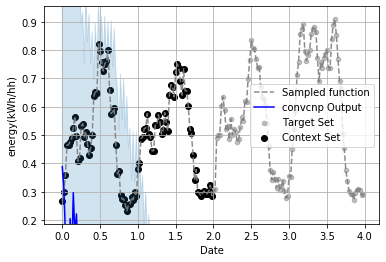


Epoch: 1/500


Training            1: 5.401e+01
Training          500: 4.649e+00


In [ ]:

plot(gen, model, args.model)

if args.train:
    # Run the training loop, maintaining the best objective value.
    best_obj = np.inf
    for epoch in tqdm(range(args.epochs)):
        print('\nEpoch: {}/{}'.format(epoch + 1, args.epochs))

        # Compute training objective.
        train_obj = train(gen, model, opt, report_freq=500)
        report_loss('Training', train_obj, 'epoch')
        writer.add_scalar('train/loss', train_obj, epoch)

        # Compute validation objective.
        val_obj = validate(gen_val, model, report_freq=200)
        report_loss('Validation', val_obj, 'epoch')
        writer.add_scalar('val/loss', val_obj, epoch)
        
        if epoch<10 or epoch%10==0:
            plot(gen_val, model, args.model)

        # Update the best objective value and checkpoint the model.
        is_best = False
        if val_obj < best_obj:
            best_obj = val_obj
            is_best = True
        save_checkpoint(wd,
                        {'epoch': epoch + 1,
                         'state_dict': model.state_dict(),
                         'best_acc_top1': best_obj,
                         'optimizer': opt.state_dict()},
                        is_best=is_best)
else:
    # Load saved model.
    load_dict = torch.load(wd.file('model_best.pth.tar', exists=True))
    model.load_state_dict(load_dict['state_dict'])

In [ ]:
 mean = self.mean_layer(x_grid, h, x_out)
ipdb> x_grid.shape
torch.Size([1, 396, 1])    
ipdb> p h.shape
torch.Size([1, 396, 8]) # self.conv_net.out_channels = 8
ipdb> x_out.shape
torch.Size([1, 192, 17])


so 8, and another 16 or 17

In [ ]:
# Finally, test model on ~2000 tasks.
test_obj = validate(gen_test, model)
print('Model averages a log-likelihood of %s on unseen tasks.' % -test_obj)
with open(wd.file('test_log_likelihood.txt'), 'w') as f:
    f.write(str(-test_obj))


# Scratch

In [ ]:
kernel = stheno.EQ().stretch(1.) + \
                 stheno.EQ().stretch(.25) + \
                 0.001 * stheno.Delta()
gen = convcnp.data.GPGenerator(kernel=kernel)
gen_val = convcnp.data.GPGenerator(kernel=kernel, num_tasks=60)
gen_test = convcnp.data.GPGenerator(kernel=kernel, num_tasks=2048)

In [ ]:
r = next(iter(gen))
{k:v.shape for k,v in r.items()}

In [ ]:
plot(gen, model, args.model)